In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # Si necesitas volver a dividir
from sklearn.preprocessing import StandardScaler   # Si necesitas volver a escalar
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, RocCurveDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones para mejor visualización
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None) # Mostrar todas las columnas
import warnings
warnings.filterwarnings('ignore') # Ignorar warnings para limpieza

# Modelado Base CVs
Iniciamos el proceso de modelado después del entendimiento

In [3]:
# --- 1. Cargar los Datos ---
csv_path = '../Bases/base_cvs/datos_para_modelar_cv.csv'
try:
    df_modelo = pd.read_csv(csv_path)
    print(f"Datos cargados exitosamente desde '{csv_path}'.")
    print(f"Dimensiones del DataFrame: {df_modelo.shape}")
    print("Primeras filas:")
    print(df_modelo.head())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path}'. Asegúrate de que esté en la ubicación correcta.")
    # Detener si no se carga
    df_modelo = None
except Exception as e:
    print(f"Error al cargar el CSV: {e}")
    df_modelo = None

Datos cargados exitosamente desde '../Bases/base_cvs/datos_para_modelar_cv.csv'.
Dimensiones del DataFrame: (614, 34)
Primeras filas:
   Passed  secciones_completas  texto_extraido_len  \
0       1                    7                3692   
1       1                    8                2703   
2       1                    9                2761   
3       1                    7                4732   
4       1                   10                4562   

   Porcentaje Lenguaje Técnico  Uso de negritas (estimado %)  \
0                         3.72                          34.4   
1                         9.61                           0.0   
2                         8.58                          21.8   
3                         6.67                          16.2   
4                        11.29                          31.2   

   Ratio_Lineas_Experiencia_len  Promedio tamaño fuente  \
0                      0.000542               16.000000   
1                      0.004440       

## Modelo: Regresión logística con la base limpia
Iniciamos el modelado con un modelo simple de regresión logística como línea de base con las variables escogidas antes


Features (X) shape: (614, 33)
Target (y) shape: (614,)

Variables numéricas a escalar: 14

Datos divididos en entrenamiento (70%) y prueba (30%).
Tamaño X_train: (491, 33), Tamaño X_test: (123, 33)
Distribución de 'Passed' en y_train:
Passed
0    0.572301
1    0.427699
Name: proportion, dtype: float64
Distribución de 'Passed' en y_test:
Passed
0    0.577236
1    0.422764
Name: proportion, dtype: float64

Escalando 14 variables numéricas...
Escalado completado (usando StandardScaler).

Entrenando modelo de Regresión Logística...
Modelo entrenado.

Realizando predicciones sobre el conjunto de prueba...

--- Evaluación del Modelo de Regresión Logística ---
Accuracy (Exactitud): 0.5122
AUC-ROC: 0.5079

Matriz de Confusión:
[[40 31]
 [29 23]]


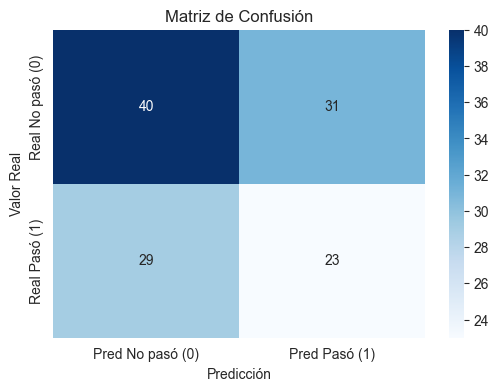


Reporte de Clasificación:
              precision    recall  f1-score   support

 No Pasó (0)       0.58      0.56      0.57        71
    Pasó (1)       0.43      0.44      0.43        52

    accuracy                           0.51       123
   macro avg       0.50      0.50      0.50       123
weighted avg       0.51      0.51      0.51       123


Generando Curva ROC...


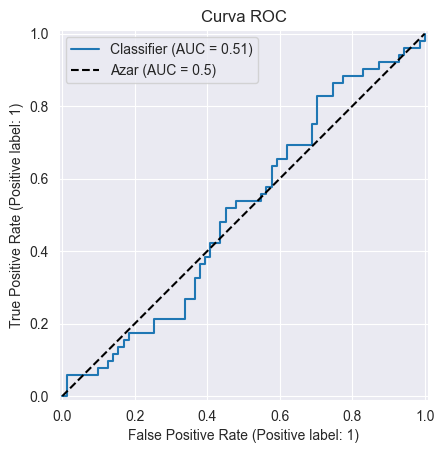

In [5]:
# --- Solo proceder si los datos se cargaron ---
if df_modelo is not None:

    # --- 2. Separar Features (X) y Target (y) ---
    target_column = 'Passed'
    if target_column not in df_modelo.columns:
        print(f"ERROR CRÍTICO: La columna objetivo '{target_column}' no se encuentra en el CSV cargado.")
    else:
        X = df_modelo.drop(columns=[target_column])
        y = df_modelo[target_column]
        print(f"\nFeatures (X) shape: {X.shape}")
        print(f"Target (y) shape: {y.shape}")

        # Identificar columnas numéricas (para escalar) y binarias (no escalar)
        # Asumimos que todas las columnas en X son numéricas (float o int, incluyendo 0/1)
        numeric_features = X.select_dtypes(include=np.number).columns.tolist()
        # Podríamos ser más específicos y separar binarias (0/1) de las continuas/discretas
        binary_features = [col for col in numeric_features if X[col].nunique() <= 2]
        continuous_discrete_features = [col for col in numeric_features if col not in binary_features]

        print(f"\nVariables numéricas a escalar: {len(continuous_discrete_features)}")
        # print(continuous_discrete_features) # Descomentar para ver la lista

        # --- 3. Dividir en Entrenamiento y Prueba ---
        # test_size=0.3 significa 30% para prueba, 70% para entrenamiento
        # random_state asegura reproducibilidad
        # stratify=y asegura que la proporción de clases 0/1 sea similar en ambos conjuntos
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            print("\nDatos divididos en entrenamiento (70%) y prueba (30%).")
            print(f"Tamaño X_train: {X_train.shape}, Tamaño X_test: {X_test.shape}")
            print(f"Distribución de 'Passed' en y_train:\n{y_train.value_counts(normalize=True)}")
            print(f"Distribución de 'Passed' en y_test:\n{y_test.value_counts(normalize=True)}")

        except Exception as e_split:
            print(f"\nError durante la división train/test: {e_split}")
            # Detener si la división falla
            X_train = None


        # --- Solo proceder si la división fue exitosa ---
        if X_train is not None:

            # --- 4. Escalar Variables Numéricas ---
            # Solo escalar las variables que no son binarias (0/1)
            print(f"\nEscalando {len(continuous_discrete_features)} variables numéricas...")
            scaler = StandardScaler()

            # Ajustar el escalador SOLO con los datos de entrenamiento
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()

            # Aplicar la transformación a las columnas numéricas (no binarias)
            X_train_scaled[continuous_discrete_features] = scaler.fit_transform(X_train[continuous_discrete_features])
            X_test_scaled[continuous_discrete_features] = scaler.transform(X_test[continuous_discrete_features])

            print("Escalado completado (usando StandardScaler).")
            # print("\nPrimeras filas de X_train escalado:")
            # print(X_train_scaled.head())


            # --- 5. Entrenar Modelo de Regresión Logística ---
            print("\nEntrenando modelo de Regresión Logística...")
            # class_weight='balanced' ayuda si las clases están desbalanceadas
            # max_iter aumentado por si no converge con el default
            log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

            try:
                log_reg.fit(X_train_scaled, y_train)
                print("Modelo entrenado.")

                # --- 6. Realizar Predicciones ---
                print("\nRealizando predicciones sobre el conjunto de prueba...")
                y_pred = log_reg.predict(X_test_scaled)
                # Obtener probabilidades para AUC
                y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

                # --- 7. Evaluar el Modelo ---
                print("\n--- Evaluación del Modelo de Regresión Logística ---")

                # Accuracy
                accuracy = accuracy_score(y_test, y_pred)
                print(f"Accuracy (Exactitud): {accuracy:.4f}")

                # Área Bajo la Curva ROC (AUC)
                try:
                    auc = roc_auc_score(y_test, y_pred_proba)
                    print(f"AUC-ROC: {auc:.4f}")
                except ValueError:
                    print("AUC-ROC no se puede calcular (posiblemente solo una clase en y_test o y_pred_proba).")
                    auc = None


                # Matriz de Confusión
                print("\nMatriz de Confusión:")
                cm = confusion_matrix(y_test, y_pred)
                print(cm)
                # Visualizarla
                try:
                    plt.figure(figsize=(6,4))
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                xticklabels=['Pred No pasó (0)', 'Pred Pasó (1)'],
                                yticklabels=['Real No pasó (0)', 'Real Pasó (1)'])
                    plt.ylabel('Valor Real')
                    plt.xlabel('Predicción')
                    plt.title('Matriz de Confusión')
                    plt.show()
                except Exception as e_cm_plot:
                     print(f"No se pudo graficar la matriz de confusión: {e_cm_plot}")


                # Reporte de Clasificación
                print("\nReporte de Clasificación:")
                report = classification_report(y_test, y_pred, target_names=['No Pasó (0)', 'Pasó (1)'])
                print(report)

                # Curva ROC (Opcional pero útil)
                if auc is not None:
                    print("\nGenerando Curva ROC...")
                    try:
                        RocCurveDisplay.from_predictions(y_test, y_pred_proba)
                        plt.title('Curva ROC')
                        plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)') # Línea de azar
                        plt.legend()
                        plt.show()
                    except Exception as e_roc_plot:
                        print(f"No se pudo graficar la curva ROC: {e_roc_plot}")

            except Exception as e_train_eval:
                 print(f"Error durante el entrenamiento o evaluación del modelo: {e_train_eval}")


La regresión lineal fue peor que el azar, intentaremos con Random Forest


## Modelo: Random Forest
Continuamos con la exploración de modelos


--- Entrenando y Evaluando Random Forest ---
Modelo Random Forest entrenado.
OOB Score estimado: 0.5051

Realizando predicciones con Random Forest...

--- Evaluación del Modelo Random Forest ---
Accuracy (Exactitud): 0.5285
AUC-ROC: 0.5066

Matriz de Confusión (Random Forest):
[[55 16]
 [42 10]]


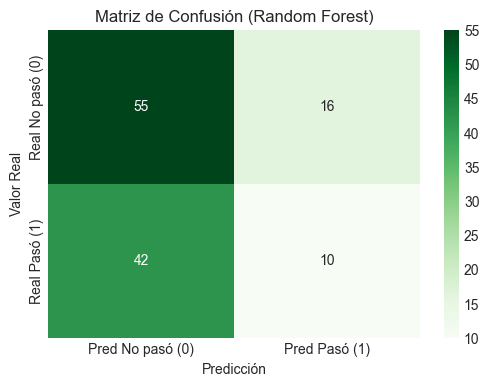


Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

 No Pasó (0)       0.57      0.77      0.65        71
    Pasó (1)       0.38      0.19      0.26        52

    accuracy                           0.53       123
   macro avg       0.48      0.48      0.46       123
weighted avg       0.49      0.53      0.49       123


Generando Curva ROC (Random Forest)...


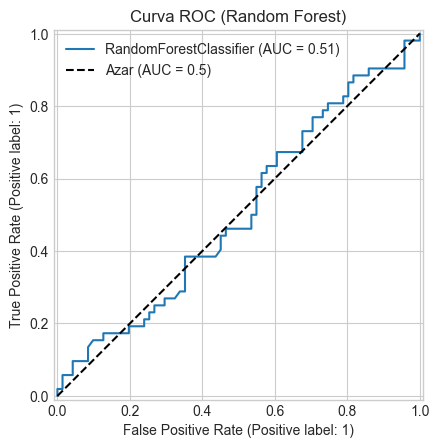

In [8]:
# --- 1. Instanciar el Modelo Random Forest ---
print("\n--- Entrenando y Evaluando Random Forest ---")

# Puedes ajustar estos parámetros, especialmente n_estimators (más árboles = más estable pero más lento)
# y potencialmente max_depth o min_samples_leaf para evitar overfitting si es necesario.
rf_clf = RandomForestClassifier(n_estimators=150,         # Número de árboles
                                random_state=42,         # Para reproducibilidad
                                n_jobs=-1,               # Usar todos los cores
                                class_weight='balanced', # Ajusta pesos si clases desbalanceadas
                                oob_score=True)          # Para estimar rendimiento sin test set

# --- 2. Entrenar el Modelo ---
try:
    # Entrenar con los datos de entrenamiento escalados
    # (RF es menos sensible al escalado que LogReg, pero no le hace daño usar los datos escalados)
    rf_clf.fit(X_train_scaled, y_train)
    print(f"Modelo Random Forest entrenado.")
    if rf_clf.oob_score_:
        print(f"OOB Score estimado: {rf_clf.oob_score_:.4f}")
    else:
        print("OOB Score no calculado.")


    # --- 3. Realizar Predicciones ---
    print("\nRealizando predicciones con Random Forest...")
    y_pred_rf = rf_clf.predict(X_test_scaled)
    y_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1] # Probabilidad de la clase '1'


    # --- 4. Evaluar el Modelo ---
    print("\n--- Evaluación del Modelo Random Forest ---")

    # Accuracy
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"Accuracy (Exactitud): {accuracy_rf:.4f}")

    # AUC-ROC
    try:
        auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
        print(f"AUC-ROC: {auc_rf:.4f}")
    except ValueError:
        print("AUC-ROC no se puede calcular.")
        auc_rf = None

    # Matriz de Confusión
    print("\nMatriz de Confusión (Random Forest):")
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    print(cm_rf)
    # Visualizarla
    try:
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', # Usar otro color
                    xticklabels=['Pred No pasó (0)', 'Pred Pasó (1)'],
                    yticklabels=['Real No pasó (0)', 'Real Pasó (1)'])
        plt.ylabel('Valor Real')
        plt.xlabel('Predicción')
        plt.title('Matriz de Confusión (Random Forest)')
        plt.show()
    except Exception as e_cm_plot_rf:
        print(f"No se pudo graficar la matriz de confusión: {e_cm_plot_rf}")

    # Reporte de Clasificación
    print("\nReporte de Clasificación (Random Forest):")
    report_rf = classification_report(y_test, y_pred_rf, target_names=['No Pasó (0)', 'Pasó (1)'])
    print(report_rf)

    # Curva ROC
    if auc_rf is not None:
        print("\nGenerando Curva ROC (Random Forest)...")
        try:
            fig, ax = plt.subplots()
            RocCurveDisplay.from_estimator(rf_clf, X_test_scaled, y_test, ax=ax)
            ax.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')
            plt.title('Curva ROC (Random Forest)')
            plt.legend()
            plt.show()
        except Exception as e_roc_plot_rf:
            print(f"No se pudo graficar la curva ROC: {e_roc_plot_rf}")

except NameError as ne:
    print(f"\nError: Parece que las variables de datos (ej. X_train_scaled) no están definidas.")
    print("Asegúrate de haber cargado los datos y ejecutado los pasos de preparación (split, scale) en este notebook.")
    print(f"Detalle: {ne}")
except Exception as e_rf_model:
    print(f"\nError durante el modelado Random Forest: {e_rf_model}")

### Conclusiones iniciales de modelado
Podemos entender que las características generales del CV no nos dan una predicción conclusiva frente si esta pasa o no pasa a un potencial siguiente filtro. De esta manera, nos remitiremos de vuelta a los análisis t-test y chi-cuadrado con el objetivo de tomar en cuenta variables que estadísticamente sabemos son significativas y podemos tener la oportunidad de explorar estos modelos y nuevos modelos.

#### Variables a tener en cuenta
1. Porcentaje de lenguaje técnico: Que aunque su t-test no es significativo, en ambas pruebas de RF mostró una importancia alta, además de un VIF bajo. *(Podríamos retirar posteriormente por su t-test)*
2. texto_extraido_len: t-test significativo y RF alto en ambas pruebas.
3. Uso de negritas (estimado %): t-test levemente significativo, alta importancia en RF y un VIF bajo.
4. Densidad Informacion (%): Aunque en el t-test no es significativo, el RF le da importancia en ambos casos *(Podríamos retirar posteriormente por su t-test)*
5. Numero de Paginas: t-test levemente significativo
6. secciones_completas: t-test significativo.
7. Website/Otro: Chi-cuadrado significativo, VIF Bajo.
8. Seccion_training_courses: Chi-cuadrado significativo.
9. Uso de colores (texto)_Sí: Chi-cuadrado levemente significativo, VIF bajo.

Estas variables tienen en cuenta nuestros análisis estadísticos anteriores y nos dejan como punto de partida varios factores dentro de una CV como lo es el Porcentaje de Lenguaje técnico, la longitud del documento, que tan y completo denso es el mísmo, además de eñ uso de colores, sitios web externos de referencia y la capacidad de aprendizaje del candidato.

## Modelado con estas nuevas variables


Features seleccionadas (X) shape: (614, 9)
Target (y) shape: (614,)

Variables numéricas a escalar: 6
['Porcentaje Lenguaje Técnico', 'texto_extraido_len', 'Uso de negritas (estimado %)', 'Densidad Informacion (%)', 'Numero de Paginas', 'secciones_completas']

Datos divididos en entrenamiento (70%) y prueba (30%).
Tamaño X_train: (429, 9), Tamaño X_test: (185, 9)

Escalando 6 variables numéricas seleccionadas...
Escalado completado.

Entrenando modelo de Regresión Logística con features seleccionadas...
Modelo entrenado.

Realizando predicciones sobre el conjunto de prueba...

--- Evaluación del Modelo de Regresión Logística (Features Seleccionadas) ---
Accuracy (Exactitud): 0.5189
AUC-ROC: 0.5229

Matriz de Confusión:
[[65 41]
 [48 31]]


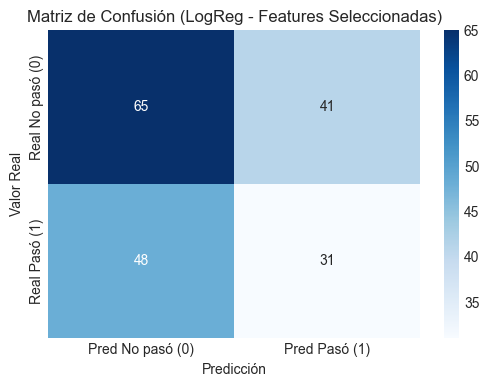


Reporte de Clasificación:
              precision    recall  f1-score   support

 No Pasó (0)       0.58      0.61      0.59       106
    Pasó (1)       0.43      0.39      0.41        79

    accuracy                           0.52       185
   macro avg       0.50      0.50      0.50       185
weighted avg       0.51      0.52      0.52       185


Generando Curva ROC...


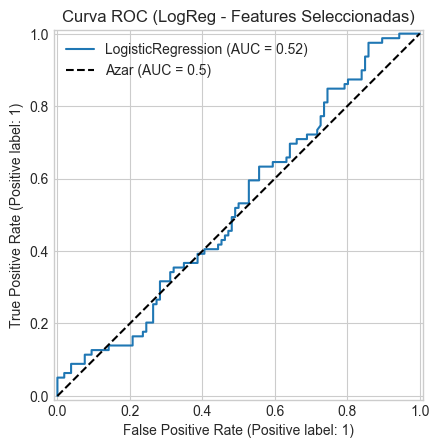

In [9]:
if df_modelo is not None:

    # --- 2. Definir Features (X) y Target (y) ---
    target_column = 'Passed'

    # *** USAR LA LISTA EXACTA DE 9 FEATURES PROPUESTA ***
    selected_features = [
        'Porcentaje Lenguaje Técnico',
        'texto_extraido_len',
        'Uso de negritas (estimado %)',
        'Densidad Informacion (%)',
        'Numero de Paginas',
        'secciones_completas',
        'Website/Otro',               # Binaria (0/1)
        'Seccion_training_courses',   # Binaria (0/1) - El flag
        'Uso de colores (texto)_Sí'   # Binaria (0/1)
    ]

    # Verificar que todas las columnas seleccionadas existen
    missing_features = [col for col in selected_features if col not in df_modelo.columns]
    if missing_features:
        print(f"\nERROR CRÍTICO: Las siguientes features seleccionadas no existen en el CSV: {missing_features}")
        X = None # Detener
    elif target_column not in df_modelo.columns:
        print(f"\nERROR CRÍTICO: La columna objetivo '{target_column}' no se encuentra en el CSV.")
        X = None # Detener
    else:
        X = df_modelo[selected_features]
        y = df_modelo[target_column]
        print(f"\nFeatures seleccionadas (X) shape: {X.shape}")
        print(f"Target (y) shape: {y.shape}")

        # Identificar columnas numéricas A ESCALAR dentro de ESTE CONJUNTO (las no binarias)
        numeric_features_to_scale = [
            'Porcentaje Lenguaje Técnico',
            'texto_extraido_len',
            'Uso de negritas (estimado %)',
            'Densidad Informacion (%)',
            'Numero de Paginas',
            'secciones_completas'
        ]
        # Asegurarse que solo escalamos las que existen en X
        numeric_features_to_scale = [col for col in numeric_features_to_scale if col in X.columns]
        print(f"\nVariables numéricas a escalar: {len(numeric_features_to_scale)}")
        print(numeric_features_to_scale)


    # --- Solo proceder si X e y se definieron ---
    if X is not None and y is not None:
        # --- 3. Dividir en Entrenamiento y Prueba ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=y # Mantener estratificación
            )
            print("\nDatos divididos en entrenamiento (70%) y prueba (30%).")
            print(f"Tamaño X_train: {X_train.shape}, Tamaño X_test: {X_test.shape}")

        except Exception as e_split:
            print(f"\nError durante la división train/test: {e_split}")
            X_train = None # Detener si falla

        # --- Solo proceder si la división fue exitosa ---
        if X_train is not None:

            # --- 4. Escalar Variables Numéricas Seleccionadas ---
            print(f"\nEscalando {len(numeric_features_to_scale)} variables numéricas seleccionadas...")
            scaler = StandardScaler()

            # Crear copias para no modificar los originales
            X_train_scaled = X_train.copy()
            X_test_scaled = X_test.copy()

            # Ajustar y transformar SOLO las columnas numéricas seleccionadas en TRAIN
            X_train_scaled[numeric_features_to_scale] = scaler.fit_transform(X_train[numeric_features_to_scale])

            # Aplicar la MISMA transformación (ya ajustada) a TEST
            X_test_scaled[numeric_features_to_scale] = scaler.transform(X_test[numeric_features_to_scale])

            print("Escalado completado.")


            # --- 5. Entrenar Modelo de Regresión Logística ---
            print("\nEntrenando modelo de Regresión Logística con features seleccionadas...")
            log_reg_final = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

            try:
                log_reg_final.fit(X_train_scaled, y_train)
                print("Modelo entrenado.")

                # --- 6. Realizar Predicciones ---
                print("\nRealizando predicciones sobre el conjunto de prueba...")
                y_pred_final = log_reg_final.predict(X_test_scaled)
                y_pred_proba_final = log_reg_final.predict_proba(X_test_scaled)[:, 1]

                # --- 7. Evaluar el Modelo ---
                print("\n--- Evaluación del Modelo de Regresión Logística (Features Seleccionadas) ---")

                accuracy_final = accuracy_score(y_test, y_pred_final)
                print(f"Accuracy (Exactitud): {accuracy_final:.4f}")

                try:
                    auc_final = roc_auc_score(y_test, y_pred_proba_final)
                    print(f"AUC-ROC: {auc_final:.4f}")
                except ValueError:
                    print("AUC-ROC no se puede calcular.")
                    auc_final = None

                print("\nMatriz de Confusión:")
                cm_final = confusion_matrix(y_test, y_pred_final)
                print(cm_final)
                # Visualizarla (opcional)
                try:
                    plt.figure(figsize=(6,4))
                    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
                                xticklabels=['Pred No pasó (0)', 'Pred Pasó (1)'],
                                yticklabels=['Real No pasó (0)', 'Real Pasó (1)'])
                    plt.ylabel('Valor Real')
                    plt.xlabel('Predicción')
                    plt.title('Matriz de Confusión (LogReg - Features Seleccionadas)')
                    plt.show()
                except Exception as e_cm_plot:
                     print(f"No se pudo graficar la matriz de confusión: {e_cm_plot}")


                print("\nReporte de Clasificación:")
                report_final = classification_report(y_test, y_pred_final, target_names=['No Pasó (0)', 'Pasó (1)'])
                print(report_final)

                if auc_final is not None:
                    print("\nGenerando Curva ROC...")
                    try:
                        RocCurveDisplay.from_estimator(log_reg_final, X_test_scaled, y_test)
                        plt.title('Curva ROC (LogReg - Features Seleccionadas)')
                        plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')
                        plt.legend()
                        plt.show()
                    except Exception as e_roc_plot:
                        print(f"No se pudo graficar la curva ROC: {e_roc_plot}")

            except Exception as e_train_eval:
                 print(f"Error durante el entrenamiento o evaluación del modelo: {e_train_eval}")

## Conclusiones 2nda iteración modelado
No fue un modelo muy bueno, dejandonos el AUC en 0.5, prácticamente al azar, a pesar de que usamos las variables que más relevancia estadística tienen frente a la variable Passed.

### Modelado: XGboost
Un modelo de árboles que construye los árboles secuencialmente corrigiendo los árboles anteriores.


--- Entrenando y Evaluando XGBoost ---
Calculando scale_pos_weight para XGBoost: 1.34
Entrenando modelo XGBoost...
Modelo XGBoost entrenado en 0.97 segundos.

Realizando predicciones con XGBoost...

--- Evaluación del Modelo XGBoost ---
Accuracy (Exactitud): 0.5243
AUC-ROC: 0.5155

Matriz de Confusión (XGBoost):
[[63 43]
 [45 34]]


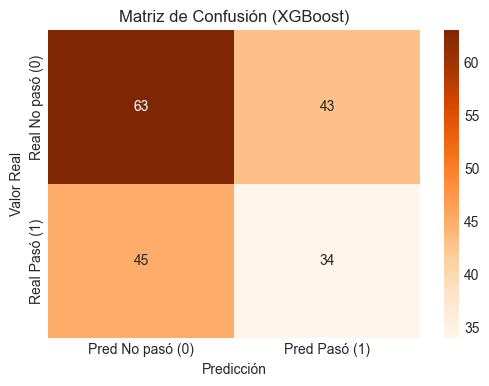


Reporte de Clasificación (XGBoost):
              precision    recall  f1-score   support

 No Pasó (0)       0.58      0.59      0.59       106
    Pasó (1)       0.44      0.43      0.44        79

    accuracy                           0.52       185
   macro avg       0.51      0.51      0.51       185
weighted avg       0.52      0.52      0.52       185


Generando Curva ROC (XGBoost)...


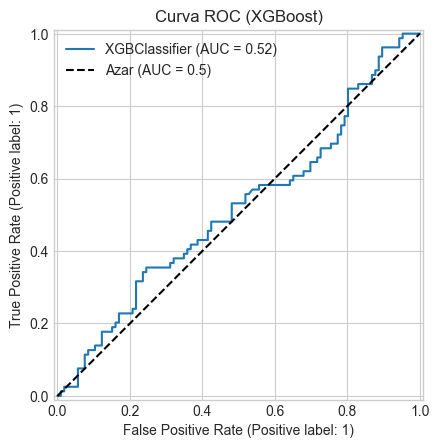

In [10]:
# --- Importaciones Adicionales (Asegúrate de tener xgboost instalado: pip install xgboost) ---
try:
    import xgboost as xgb
except ImportError:
    print("Error: Necesitas instalar xgboost. Ejecuta: pip install xgboost")
    xgb = None # Para evitar errores posteriores si no está instalado

import time # Para medir tiempo de entrenamiento (opcional)

# --- Asumimos que X_train_scaled, X_test_scaled, y_train, y_test existen ---
if xgb is not None and 'X_train_scaled' in locals(): # Verificar si XGBoost y los datos están disponibles

    print("\n--- Entrenando y Evaluando XGBoost ---")

    # --- 1. Instanciar el Modelo XGBoost ---
    # Calcular scale_pos_weight para manejar desbalanceo (si existe)
    # Es la ratio de muestras negativas a positivas en el set de entrenamiento
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1) if sum(y_train == 1) > 0 else 1
    print(f"Calculando scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

    xgb_clf = xgb.XGBClassifier(
        objective='binary:logistic', # Objetivo de clasificación binaria
        eval_metric='logloss',       # Métrica para monitorear (no afecta resultado final aquí)
        scale_pos_weight=scale_pos_weight, # Para manejar desbalanceo
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False      # Práctica recomendada
    )

    # --- 2. Entrenar el Modelo ---
    print("Entrenando modelo XGBoost...")
    start_time = time.time()
    try:
        xgb_clf.fit(X_train_scaled, y_train)
        end_time = time.time()
        print(f"Modelo XGBoost entrenado en {end_time - start_time:.2f} segundos.")

        # --- 3. Realizar Predicciones ---
        print("\nRealizando predicciones con XGBoost...")
        y_pred_xgb = xgb_clf.predict(X_test_scaled)
        y_pred_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]

        # --- 4. Evaluar el Modelo ---
        print("\n--- Evaluación del Modelo XGBoost ---")

        accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
        print(f"Accuracy (Exactitud): {accuracy_xgb:.4f}")

        try:
            auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
            print(f"AUC-ROC: {auc_xgb:.4f}")
        except ValueError:
            print("AUC-ROC no se puede calcular.")
            auc_xgb = None

        print("\nMatriz de Confusión (XGBoost):")
        cm_xgb = confusion_matrix(y_test, y_pred_xgb)
        print(cm_xgb)
        # Visualizarla (opcional)
        try:
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
                        xticklabels=['Pred No pasó (0)', 'Pred Pasó (1)'],
                        yticklabels=['Real No pasó (0)', 'Real Pasó (1)'])
            plt.ylabel('Valor Real'); plt.xlabel('Predicción'); plt.title('Matriz de Confusión (XGBoost)')
            plt.show()
        except Exception as e_cm_plot_xgb: print(f"No se pudo graficar matriz: {e_cm_plot_xgb}")


        print("\nReporte de Clasificación (XGBoost):")
        report_xgb = classification_report(y_test, y_pred_xgb, target_names=['No Pasó (0)', 'Pasó (1)'])
        print(report_xgb)

        if auc_xgb is not None:
            print("\nGenerando Curva ROC (XGBoost)...")
            try:
                fig, ax = plt.subplots()
                RocCurveDisplay.from_estimator(xgb_clf, X_test_scaled, y_test, ax=ax)
                ax.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')
                plt.title('Curva ROC (XGBoost)')
                plt.legend()
                plt.show()
            except Exception as e_roc_plot_xgb: print(f"No se pudo graficar curva ROC: {e_roc_plot_xgb}")

    except Exception as e_xgb_model:
        print(f"\nError durante el modelado XGBoost: {e_xgb_model}")

elif xgb is None:
     print("\nXGBoost no está instalado. Omiteindo este modelo.")

### Modelado: SVM
La maquina de soporte vectorial realiza un enfoque diferente, ya no por árboles pero encontrando un hiperplano óptimo frente a las diferentes clases.


--- Entrenando y Evaluando Support Vector Machine (SVM) ---
Entrenando modelo SVM (RBF Kernel)...
Modelo SVM (RBF Kernel) entrenado en 0.07 segundos.

Realizando predicciones con SVM (RBF Kernel)...

--- Evaluación del Modelo SVM (RBF Kernel) ---
Accuracy (Exactitud): 0.4973
AUC-ROC: 0.4864

Matriz de Confusión (SVM (RBF Kernel)):
[[55 51]
 [42 37]]


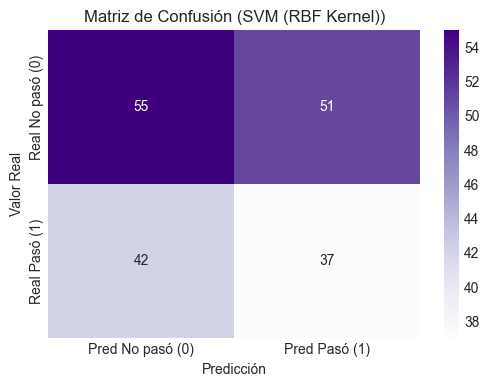


Reporte de Clasificación (SVM (RBF Kernel)):
              precision    recall  f1-score   support

 No Pasó (0)       0.57      0.52      0.54       106
    Pasó (1)       0.42      0.47      0.44        79

    accuracy                           0.50       185
   macro avg       0.49      0.49      0.49       185
weighted avg       0.50      0.50      0.50       185


Generando Curva ROC (SVM (RBF Kernel))...


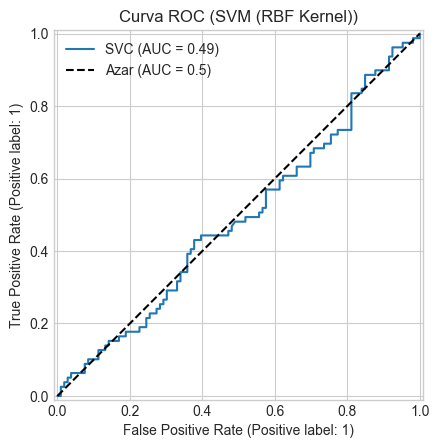

In [11]:
# --- Importaciones Adicionales ---
from sklearn.svm import SVC

# --- Asumimos que X_train_scaled, X_test_scaled, y_train, y_test existen ---
if 'X_train_scaled' in locals(): # Verificar si los datos están disponibles

    print("\n--- Entrenando y Evaluando Support Vector Machine (SVM) ---")

    # --- 1. Instanciar el Modelo SVM ---
    # Probaremos con kernel 'rbf' (común y potente) y 'linear'
    # probability=True es necesario para predict_proba y AUC, pero puede hacer el entrenamiento más lento
    # class_weight='balanced' para manejar desbalanceo
    svm_rbf = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
    # svm_linear = SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced') # Alternativa lineal

    # Selecciona cuál probar o prueba ambos:
    svm_model = svm_rbf
    model_name = "SVM (RBF Kernel)"
    # svm_model = svm_linear
    # model_name = "SVM (Linear Kernel)"

    # --- 2. Entrenar el Modelo ---
    print(f"Entrenando modelo {model_name}...")
    start_time = time.time()
    try:
        svm_model.fit(X_train_scaled, y_train)
        end_time = time.time()
        print(f"Modelo {model_name} entrenado en {end_time - start_time:.2f} segundos.")

        # --- 3. Realizar Predicciones ---
        print(f"\nRealizando predicciones con {model_name}...")
        y_pred_svm = svm_model.predict(X_test_scaled)
        y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

        # --- 4. Evaluar el Modelo ---
        print(f"\n--- Evaluación del Modelo {model_name} ---")

        accuracy_svm = accuracy_score(y_test, y_pred_svm)
        print(f"Accuracy (Exactitud): {accuracy_svm:.4f}")

        try:
            auc_svm = roc_auc_score(y_test, y_pred_proba_svm)
            print(f"AUC-ROC: {auc_svm:.4f}")
        except ValueError:
            print("AUC-ROC no se puede calcular.")
            auc_svm = None

        print(f"\nMatriz de Confusión ({model_name}):")
        cm_svm = confusion_matrix(y_test, y_pred_svm)
        print(cm_svm)
        # Visualizarla (opcional)
        try:
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
                        xticklabels=['Pred No pasó (0)', 'Pred Pasó (1)'],
                        yticklabels=['Real No pasó (0)', 'Real Pasó (1)'])
            plt.ylabel('Valor Real'); plt.xlabel('Predicción'); plt.title(f'Matriz de Confusión ({model_name})')
            plt.show()
        except Exception as e_cm_plot_svm: print(f"No se pudo graficar matriz: {e_cm_plot_svm}")


        print(f"\nReporte de Clasificación ({model_name}):")
        report_svm = classification_report(y_test, y_pred_svm, target_names=['No Pasó (0)', 'Pasó (1)'])
        print(report_svm)

        if auc_svm is not None:
            print(f"\nGenerando Curva ROC ({model_name})...")
            try:
                fig, ax = plt.subplots()
                RocCurveDisplay.from_estimator(svm_model, X_test_scaled, y_test, ax=ax)
                ax.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')
                plt.title(f'Curva ROC ({model_name})')
                plt.legend()
                plt.show()
            except Exception as e_roc_plot_svm: print(f"No se pudo graficar curva ROC: {e_roc_plot_svm}")

    except Exception as e_svm_model:
        print(f"\nError durante el modelado SVM: {e_svm_model}")

### Conclusiones nuevos modelos
Los modelos presentados no encontraron una fuerza predictiva significativa a pesar de la reducción de variables que realizamos. Como intento final con el dataset, realizaremos la prueba de modelado con las variables cuya relevancia estadística se demostró en los t-test y pruebas chi-cuadrad

### Modelado: 4 variables

In [12]:
# --- Solo proceder si los datos se cargaron ---
if df_modelo is not None:

    # --- 2. Definir Features (X) y Target (y) ---
    target_column = 'Passed'
    # *** USAR SOLO LAS 4 FEATURES SIGNIFICATIVAS (p<0.05) ***
    significant_features = [
        'texto_extraido_len',       # Numérica
        'secciones_completas',      # Numérica
        'Website/Otro',             # Binaria (0/1)
        'Seccion_training_courses'  # Binaria (0/1) - El flag
    ]

    # Verificar que las columnas existan
    missing_features = [col for col in significant_features if col not in df_modelo.columns]
    if missing_features:
        print(f"\nERROR CRÍTICO: Features significativas no encontradas: {missing_features}")
        X = None
    elif target_column not in df_modelo.columns:
        print(f"\nERROR CRÍTICO: Columna objetivo '{target_column}' no encontrada.")
        X = None
    else:
        X = df_modelo[significant_features]
        y = df_modelo[target_column]
        print(f"\nFeatures seleccionadas (Significativas) (X) shape: {X.shape}")
        print(f"Target (y) shape: {y.shape}")

        # Identificar columnas numéricas A ESCALAR (de estas 4)
        numeric_features_to_scale_simple = [
             'texto_extraido_len',
             'secciones_completas'
        ]
        # Asegurarse que existen en X antes de escalar
        numeric_features_to_scale_simple = [col for col in numeric_features_to_scale_simple if col in X.columns]
        print(f"\nVariables numéricas a escalar: {len(numeric_features_to_scale_simple)}")


    # --- Solo proceder si X e y se definieron ---
    if X is not None and y is not None:
        # --- 3. Dividir en Entrenamiento y Prueba ---
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=y
            )
            print("\nDatos divididos en entrenamiento (70%) y prueba (30%).")
        except Exception as e_split:
            print(f"\nError durante la división train/test: {e_split}")
            X_train = None

        # --- Solo proceder si la división fue exitosa ---
        if X_train is not None:

            # --- 4. Escalar Variables Numéricas Seleccionadas ---
            print(f"\nEscalando {len(numeric_features_to_scale_simple)} variables numéricas...")
            scaler_simple = StandardScaler()
            X_train_scaled_simple = X_train.copy()
            X_test_scaled_simple = X_test.copy()

            # Ajustar y transformar SOLO en TRAIN, luego transformar TEST
            X_train_scaled_simple[numeric_features_to_scale_simple] = scaler_simple.fit_transform(X_train[numeric_features_to_scale_simple])
            X_test_scaled_simple[numeric_features_to_scale_simple] = scaler_simple.transform(X_test[numeric_features_to_scale_simple])
            print("Escalado completado.")


            # --- 5. Entrenar Modelo de Regresión Logística (Simplificado) ---
            print("\nEntrenando modelo de Regresión Logística (Features Significativas)...")
            log_reg_simple = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

            try:
                log_reg_simple.fit(X_train_scaled_simple, y_train)
                print("Modelo simplificado entrenado.")

                # --- 6. Realizar Predicciones ---
                print("\nRealizando predicciones...")
                y_pred_simple = log_reg_simple.predict(X_test_scaled_simple)
                y_pred_proba_simple = log_reg_simple.predict_proba(X_test_scaled_simple)[:, 1]

                # --- 7. Evaluar el Modelo ---
                print("\n--- Evaluación del Modelo Logístico Simplificado ---")
                accuracy_simple = accuracy_score(y_test, y_pred_simple)
                print(f"Accuracy (Exactitud): {accuracy_simple:.4f}")
                try:
                    auc_simple = roc_auc_score(y_test, y_pred_proba_simple)
                    print(f"AUC-ROC: {auc_simple:.4f}")
                except ValueError: auc_simple = None; print("AUC-ROC no calculable.")
                print("\nMatriz de Confusión:"); print(confusion_matrix(y_test, y_pred_simple))
                print("\nReporte de Clasificación:"); print(classification_report(y_test, y_pred_simple, target_names=['No Pasó (0)', 'Pasó (1)']))
                # (Opcional: Graficar Matriz y ROC)

            except Exception as e_train_eval:
                 print(f"Error durante el entrenamiento o evaluación del modelo simplificado: {e_train_eval}")


Features seleccionadas (Significativas) (X) shape: (614, 4)
Target (y) shape: (614,)

Variables numéricas a escalar: 2

Datos divididos en entrenamiento (70%) y prueba (30%).

Escalando 2 variables numéricas...
Escalado completado.

Entrenando modelo de Regresión Logística (Features Significativas)...
Modelo simplificado entrenado.

Realizando predicciones...

--- Evaluación del Modelo Logístico Simplificado ---
Accuracy (Exactitud): 0.5189
AUC-ROC: 0.5054

Matriz de Confusión:
[[65 41]
 [48 31]]

Reporte de Clasificación:
              precision    recall  f1-score   support

 No Pasó (0)       0.58      0.61      0.59       106
    Pasó (1)       0.43      0.39      0.41        79

    accuracy                           0.52       185
   macro avg       0.50      0.50      0.50       185
weighted avg       0.51      0.52      0.52       185



## Conclusiones de modelado

En esta ocasión particular, hemos visto la oportunidad de generar un modelo predictivo con base en las variables obtenidas para predecir la variable 'Passed', lo cual nos deja varias cosas para hacer:

1. Cambiar el enfoque, a utilizar un modelo k-means, el cual nos permita identificar grupos de HVs, entendiendo sus características principales y teniendo la oportunidad de identificar desde estos grupos también, cuales tienen mayor participación en la variable passed.

##### Para posterior a la terminación del proyecto y como próximos pasos.
2. Refinar el algorítmo de obtención de información de la CV, que por limitaciones técnicas del proyecto no ha podido ser el caso, pero que nos permita obtener mas detalles y variables extraidas que quizá permitan predecir si una CV puede o no pasar (O por el contrario, concluir definitivamente que no es posible predecirla desde sus carácterísticas de forma)
3. Intentar los pasos de extracción y modelado con una base significativamente mayor de HVs. Es posible que los modelos no estén funcionando de la manera esperado dada una aparente cantidad limitada de CVs.

Para una posterior investigación y continuar la exploración de la predicción para dichos modelos, cumpliendo el mismo objetivo de aumentar la conversión de CVs enviadas y pasar a entrevista.